## glypy Quickstart

The basic building block of a glycan is a monosaccharide. Monosaccharides are an extremely diverse family of molecules, but their features are relatively consistent across these variations. 

The object-model in `glypy` is designed to let you specify aspects of a monosaccharide without placing each carbon by hand, but still allowing you full control over the gross structure of the object.

In [1]:
import glypy
monosaccharide = glypy.Monosaccharide(anomer='beta', superclass='hex', configuration='d', stem='glc', ring_start=1, ring_end=5)
print(monosaccharide)
monosaccharide.mass()

RES 1b:b-dglc-HEX-1:5


180.0633881022

Behold, [Glucose](http://www.monosaccharidedb.org/display_monosaccharide.action?id=4). If you follow the link to MonosaccharideDB, you'll see that the mass reported is the monoisotopic mass of the monosaccharide.

By default, all sugars are printed out in *condensed GlycoCT* format.

Here, we've made a monosaccharide whose anomeric carbon is in the $\beta$ configuration, whose backbone contains six carbons, forming a right-handed stereo-structure, with the ring topology of Glucose, starting at carbon 1 and closing at carbon 5.

That was a lot to write for just a molecule of glucose. For convenience, you can also create new common monosaccharides by:

In [2]:
glypy.monosaccharides['Glucose']

RES 1b:b-dglc-HEX-1:5

There is a long list of available names available, some of which are synonyms.

In [3]:
print(glypy.monosaccharides["Glc"])
print('--')
print(glypy.monosaccharides["Glucose"])
print('--')
print(glypy.monosaccharides["bdGlc"])

RES 1b:b-dglc-HEX-1:5
--
RES 1b:b-dglc-HEX-1:5
--
RES 1b:b-dglc-HEX-1:5


Because there are so many names for the same thing, it can sometimes be useful to consult a synonym index or an identity test if you happen upon a name you do not recognize

In [4]:
from glypy.io.nomenclature import synonyms, identity

print(synonyms.monosaccharides['Glc'])
identity.is_a(monosaccharide, "Glucose")

[u'Glucose', u'bdGlc', u'LinearCode:G']


True

### Putting Pieces Together

In [5]:
monosaccharides = glypy.monosaccharides

glcnac1 = monosaccharides["GlcNAc"]
glcnac2 = monosaccharides["GlcNAc"]

glcnac1.add_monosaccharide(glcnac2, position=4, child_position=1)
bdman = monosaccharides["bdMan"]
glcnac2.add_monosaccharide(bdman, position=4, child_position=1)
adman1 = monosaccharides["adMan"]
bdman.add_monosaccharide(adman1, position=3, child_position=1)
adman2 = monosaccharides["adMan"]
bdman.add_monosaccharide(adman2, position=6, child_position=1)

n_linked_core = glypy.Glycan(root=glcnac1)
n_linked_core.reindex(hard=True)
n_linked_core.canonicalize()
print(n_linked_core)
print(n_linked_core.mass())
print(n_linked_core.total_composition())

RES
1b:b-dglc-HEX-1:5
2s:n-acetyl
3b:b-dglc-HEX-1:5
4s:n-acetyl
5b:b-dman-HEX-1:5
6b:a-dman-HEX-1:5
7b:a-dman-HEX-1:5
LIN
1:1d(2+1)2n
2:1o(4+1)3d
3:3d(2+1)4n
4:3o(4+1)5d
5:5o(3+1)6d
6:5o(6+1)7d

910.327779978
Composition({'H': 58, 'C': 34, 'O': 26, 'N': 2})


What we did here created each monosaccharide unit that composes the core of an N-linked glycan, and connected them together to form a tree or graph structure. Each bond links a parent residue to one of its children in the language of trees, where the first parent is the residue at the reducing end.

At the end, in order to create something aware of the entire tree structure and not just an individual node in it, we created an instance of the `Glycan` class from the first residue, the root of the tree. We force it to build an ordered index by calling `reindex` with `hard=True`, and then canonicalizing the structure with `canonicalize` to ensure that the structure is traversed canonically.

To see what we made here, we can look at both a textual representation and an image of the tree

(RES 1b:b-dglc-HEX-1:5 2s:n-acetyl LIN 1:1d(2+1)2n: id=1  x=3.06161699787e-17 mod=0,
 <matplotlib.axes._subplots.AxesSubplot at 0xaee0c18>)

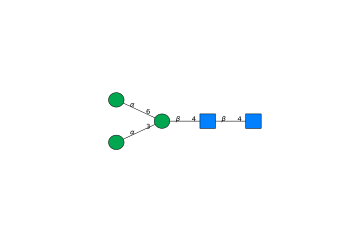

In [6]:
from glypy.plot import plot
%matplotlib inline
from IPython import display
display.set_matplotlib_formats('svg')
plot(n_linked_core, label=True)

The process of putting together all of those building blocks can be repetative as well, so the N-glycan core structure is made available in `glypy.glycans` just as `glypy.monosaccharides` provided a shortcut for creating individual monosaccharides

In [7]:
premade_core = glypy.glycans['N-Linked Core']
premade_core == n_linked_core

True

### Operating on Glycans
The real use for this library comes from manipulating glycan structure. We can add and remove monosaccharides, substituents, and modifications per base, derivatize the whole glycan structure, and generate fragments.

Basic operations such as iteration traverse the glycan structure using a depth-first traversal that selects branches by bond order.

In [8]:
accumulated_total_mass = 0
for monosaccharide in n_linked_core:
    print(monosaccharide)
    print(monosaccharide.mass())
    accumulated_total_mass += monosaccharide.mass()
    print('-------------')

print(accumulated_total_mass, n_linked_core.mass())

RES 1b:b-dglc-HEX-1:5 2s:n-acetyl LIN 1:1d(2+1)2n
220.082112171
-------------
RES 1b:b-dglc-HEX-1:5 2s:n-acetyl LIN 1:1d(2+1)2n
203.07937252
-------------
RES 1b:b-dman-HEX-1:5
161.044998386
-------------
RES 1b:a-dman-HEX-1:5
163.060648451
-------------
RES 1b:a-dman-HEX-1:5
163.060648451
-------------
(910.32777997822, 910.32777997822)


This shows each distinct monosaccharide unit composing the total structure and their discrete masses after composition loss from forming glycosidic bonds. This total mass is the same as mass of the glycan.

We can traverse the structure in many other ways using the `iternodes` function, which is called by the [Python iterator protocol](https://docs.python.org/2/library/stdtypes.html#iterator-types), `__iter__`. A feature worth pointing out is that the `iternodes` function allows you to pass a callback to influence how it emits residues. For instance, `Glycan.leaves()` is implemented similar to this

In [9]:
import itertools

def leaves(self):
    def is_leaf(obj):
        if len(list(obj.children())) == 0:
            yield obj

    return itertools.chain.from_iterable(self.iternodes(apply_fn=is_leaf))
    
print("The leaf nodes, or `terminal nodes` of the N-linked core")
for leaf in leaves(n_linked_core):
    print(leaf)
    print('---')

The leaf nodes, or `terminal nodes` of the N-linked core
RES 1b:a-dman-HEX-1:5
---
RES 1b:a-dman-HEX-1:5
---


As you can see, if you can create a sequence of only nodes that satisfy some constraint, such as number of child nodes, it is easy to build an iterator pipeline to perform more complex graph transformations. You can also iterate over each link in the glycan using `Glycan.iterlinks()`. This is useful if you want to perform an operation on each `Link` object.

Like breaking them.

#### Glycan Fragmentation

A core goal of `glypy` is supporting flexible glycan fragmentation. An example of this operation with the N-linked core:

In [10]:
for fragment_ion in n_linked_core.fragments():
    print(fragment_ion.name, fragment_ion.mass)

('Y2', 221.08993720321)
('B2', 689.2378427750101)
('Y1', 424.16930972272)
('B3', 486.1584702555)
('Ya1', 748.2749565597201)
('Ba3', 162.0528234185)
('Yb1', 748.2749565597201)
('Bb3', 162.0528234185)


To connect a fragment to its place in the original structure, you can retrieve the disjoint sub-trees from a fragmentation by using the function `fragment_to_substructure` in the `glycan` module.


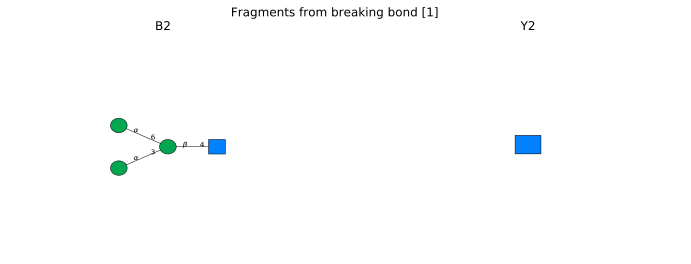

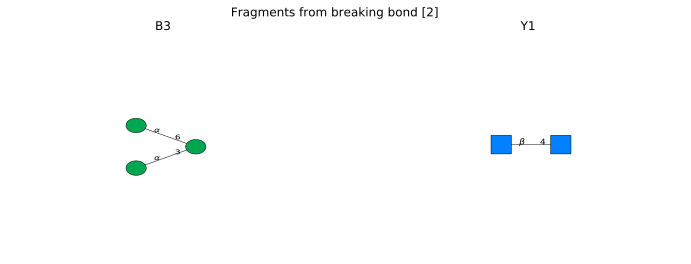

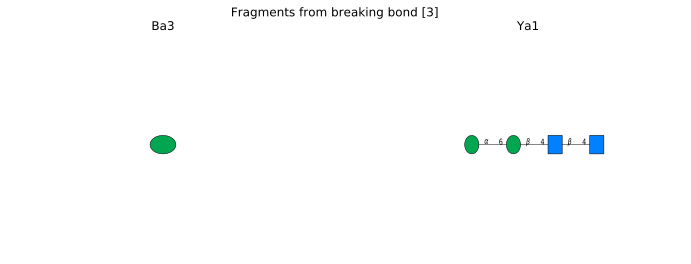

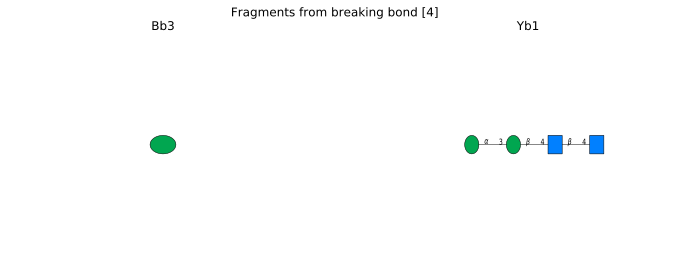

In [11]:
from matplotlib import pyplot as plt
from glypy.structure.glycan import fragment_to_substructure

for links, frags in itertools.groupby(n_linked_core.clone().fragments(), lambda f: f.link_ids.keys()):
    frags = list(frags)
    y_ion, b_ion = frags
    y_tree, b_tree = [fragment_to_substructure(frag, n_linked_core) for frag in (y_ion, b_ion)]
    
    fig, axes = plt.subplots(1,2)
    b_ax, y_ax = axes
    fig.set_size_inches(12, 4)
    plot(y_tree, ax=y_ax, center=True, label=True)
    plot(b_tree, ax=b_ax, center=True, label=True)
    b_ax.axis('off'), y_ax.axis('off')
    y_ax.set_title(n_linked_core.name_fragment(y_ion))
    b_ax.set_title(n_linked_core.name_fragment(b_ion))
    fig.suptitle("Fragments from breaking bond {}".format(links))

    

The `Glycan.fragments()` algorithm mutates the object, iteratively as removing and restoring links between the constituent `Monosaccharide` objects. Because we want to use the object's structure for `fragment_to_substructure`, it is important to copy the object before fragmenting it. All of `glypy`'s common structures, `Glycan, Monosaccharide, Link, Substituent,` and `ReducedEnd` have a `clone` method. 

This is all useful, but what we probably want something more complex than just the core structure to work with. GlycomeDB is the most up-to-date (at the time of this writing) functional Glycomics database. Taking [Entry 183](http://www.glycome-db.org/database/showStructure.action?glycomeId=183), we can get something a little more complicated. 

It would be a nuisance to have to manually create each residue, and as we've already seen, `glypy` knows about `GlycoCT`

RES
1b:b-dglc-HEX-1:5
2s:n-acetyl
3b:b-dglc-HEX-1:5
4s:n-acetyl
5b:b-dman-HEX-1:5
6b:a-dman-HEX-1:5
7b:b-dglc-HEX-1:5
8s:n-acetyl
9b:b-dgal-HEX-1:5
10b:b-dglc-HEX-1:5
11s:n-acetyl
12b:b-dgal-HEX-1:5
13b:a-dman-HEX-1:5
14b:b-dglc-HEX-1:5
15s:n-acetyl
16b:b-dgal-HEX-1:5
LIN
1:1d(2+1)2n
2:1o(4+1)3d
3:3d(2+1)4n
4:3o(4+1)5d
5:5o(3+1)6d
6:6o(2+1)7d
7:7d(2+1)8n
8:7o(4+1)9d
9:6o(4+1)10d
10:10d(2+1)11n
11:10o(4+1)12d
12:5o(6+1)13d
13:13o(2+1)14d
14:14d(2+1)15n
15:14o(4+1)16d

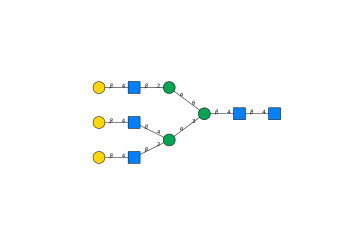

In [12]:
from glypy.io import glycoct

glycomedb183_glycoct = '''
RES
1b:b-dglc-HEX-1:5
2s:n-acetyl
3b:b-dglc-HEX-1:5
4s:n-acetyl
5b:b-dman-HEX-1:5
6b:a-dman-HEX-1:5
7b:b-dglc-HEX-1:5
8s:n-acetyl
9b:b-dgal-HEX-1:5
10b:b-dglc-HEX-1:5
11s:n-acetyl
12b:b-dgal-HEX-1:5
13b:a-dman-HEX-1:5
14b:b-dglc-HEX-1:5
15s:n-acetyl
16b:b-dgal-HEX-1:5
LIN
1:1d(2+1)2n
2:1o(4+1)3d
3:3d(2+1)4n
4:3o(4+1)5d
5:5o(3+1)6d
6:6o(2+1)7d
7:7d(2+1)8n
8:7o(4+1)9d
9:6o(4+1)10d
10:10d(2+1)11n
11:10o(4+1)12d
12:5o(6+1)13d
13:13o(2+1)14d
14:14d(2+1)15n
15:14o(4+1)16d
'''

glycomedb183 = glycoct.loads(glycomedb183_glycoct)
plot(glycomedb183, label=True)
glycomedb183

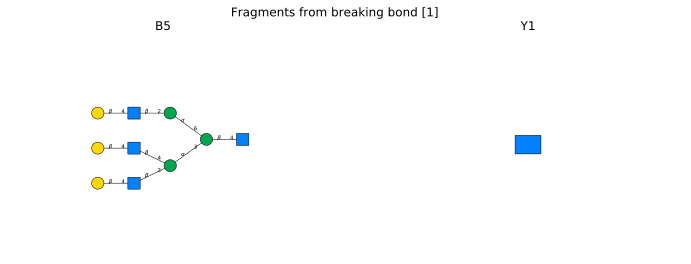

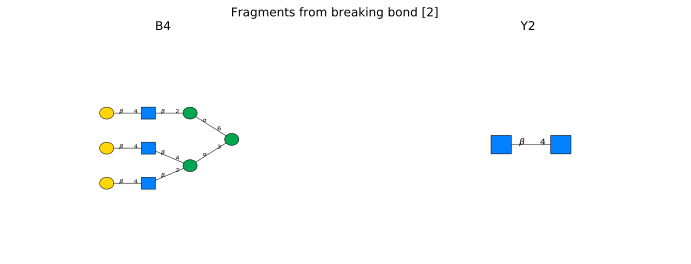

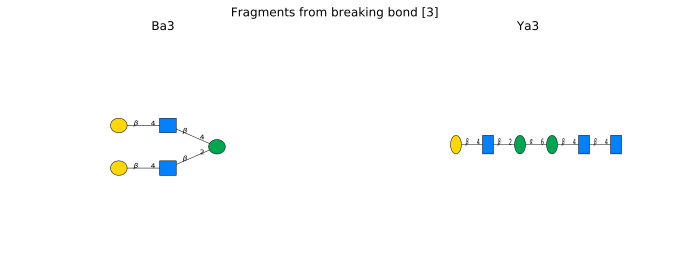

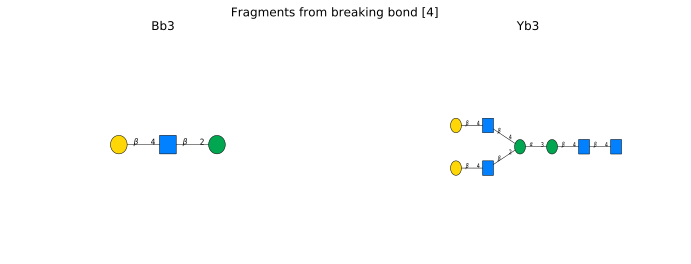

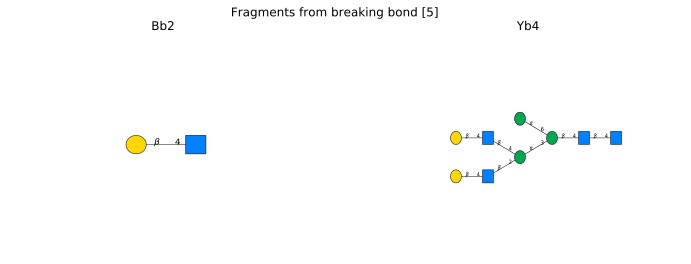

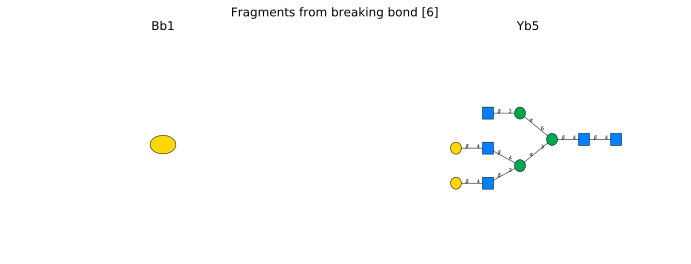

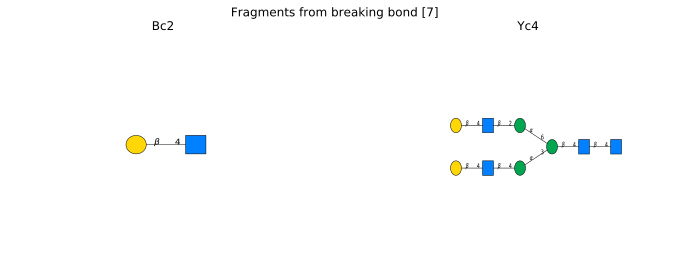

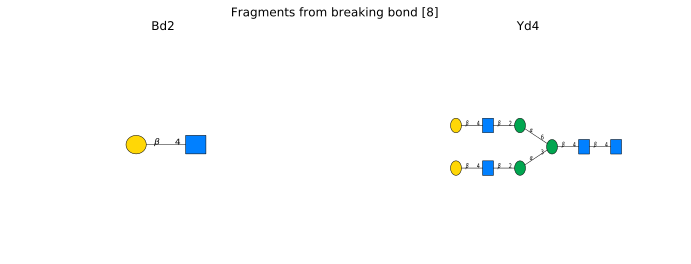

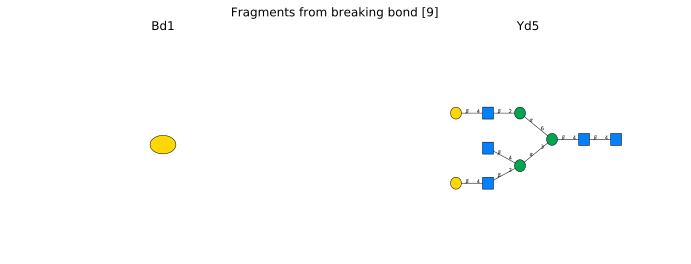

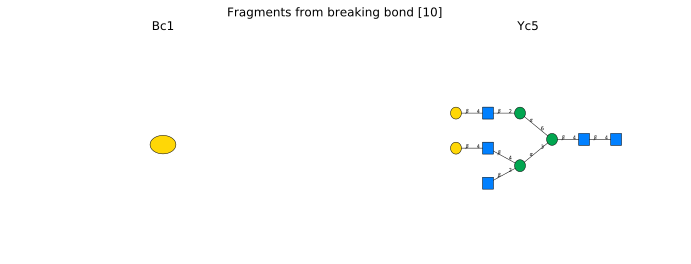

In [13]:
for links, frags in itertools.groupby(glycomedb183.clone().fragments(), lambda f: f.link_ids.keys()):
    
    y_ion, b_ion = frags
    y_tree, b_tree = [fragment_to_substructure(frag, glycomedb183) for frag in (y_ion, b_ion)]
    
    fig, axes = plt.subplots(1,2)
    b_ax, y_ax = axes
    fig.set_size_inches(12, 4)
    plot(y_tree, ax=y_ax, center=True, label=True)
    plot(b_tree, ax=b_ax, center=True, label=True)
    y_ax.set_title(glycomedb183.name_fragment(y_ion))
    b_ax.set_title(glycomedb183.name_fragment(b_ion))
    b_ax.axis('off'), y_ax.axis('off')
    fig.suptitle("Fragments from breaking bond {}".format(links))

    

### Derivatization

So this structure is fancier than our last case, but we're probably not studying it in its native state. Permethylation is a popular technique for glycan analysis in glycan mass spectrometry. 

In [14]:
from glypy.composition.composition_transform import derivatize

case = glycomedb183.clone()
print("Clone is identical? {}".format(case == glycomedb183))

derivatize(case, 'methyl')
print("Clone is identical? {}".format(case == glycomedb183))

print("Derivatized Mass: {}, Native Mass: {}, Mass Delta: {}".format(
        case.mass(), glycomedb183.mass(), case.mass() - glycomedb183.mass()))


Clone is identical? True
Clone is identical? False
Derivatized Mass: 2496.27212004, Native Mass: 2005.72436779, Mass Delta: 490.547752245
